# Data Pre-Processing

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo
import data_handler as dh

In [43]:
bank_marketing = fetch_ucirepo(id=222)
X_bank_marketing, y_bank_marketing = bank_marketing.data.features, bank_marketing.data.targets

wine_quality = fetch_ucirepo(id=186)
X_wine_quality, y_wine_quality = wine_quality.data.features, wine_quality.data.targets

We pre-process the bank marketing data like last week.

In [44]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'], axis=1)  # drop features without value for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (
        X_bank_marketing.max() - X_bank_marketing.min())  # normalize the data

y_bank_marketing = y_bank_marketing.copy()
y_bank_marketing['y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1})  # convert targets to numeric values

[Empty Markdown]

In [45]:
X_wine_quality = (X_wine_quality - X_wine_quality.min()) / (X_wine_quality.max() - X_wine_quality.min())
y_wine_quality = (y_wine_quality - y_wine_quality.min()) / (y_wine_quality.max() - y_wine_quality.min())

In [46]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = dh.split_data(X_bank_marketing, y_bank_marketing, 0.8)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = dh.split_data(X_wine_quality, y_wine_quality, 0.8)

# Regularization
We are going to implement Ridge Regression according to the SGD algorithm on exercise sheet 4. The only difference is that we use 50 samples at once.

## Ridge Gradient Descent
For the wine quality dataset, we implement a Ridge Regression model, with MSE as loss function:

$$
Loss = \frac{1}{n} \sum_{i=1}^{n} (y_i - (x_i \beta + b))^2 + \lambda \sum_{j=1}^{P} \beta_j^2
$$

The gradient with respect to $\beta$ is:

$$
\Delta_{\beta} Loss = - \frac{2}{n} X^T (y - X \beta) + 2 \lambda \beta
$$

The bias term gradient is:

$$
\Delta_{b} Loss = \frac{2}{n} \sum_{i=1}^n ((x_i \beta + b) - y_i)
$$



In [158]:
class RidgeRegression:
    def __init__(self):
        self.B = None
        self.bias = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50, tolerance=1e-3, clip_value=10):
        n, d = X_train.shape
        self.B = np.zeros(d)
        self.bias = 0
        patience = 5
        patience_counter = 0
        best_rmse = float('inf')

        train_rmse_history = []
        test_rmse_history = []

        learning_rate = initial_learning_rate
        bold_driver_reward = 1.1
        bold_driver_penalty = 0.5

        for epoch in range(1, i_max + 1):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            prev_rmse = None

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = (X_batch @ self.B) + self.bias

                gradient_B = -(2 / len(y_batch)) * X_batch.T @ (y_batch - y_pred) + 2 * regularization_constant * self.B
                gradient_bias = -(2 / len(y_batch)) * np.sum(y_batch - y_pred)

                # gradient clipping required to prevent overflows lol
                gradient_B_norm = np.linalg.norm(gradient_B)
                if gradient_B_norm > clip_value:
                    gradient_B = (gradient_B / gradient_B_norm) * clip_value

                gradient_bias_norm = np.linalg.norm(gradient_bias)
                if gradient_bias_norm > clip_value:
                    gradient_bias = (gradient_bias / gradient_bias_norm) * clip_value

                B_prev = self.B.copy()
                L2_prev = self.bias

                self.B -= learning_rate * gradient_B
                self.bias -= learning_rate * gradient_bias

                y_batch_pred = (X_batch @ self.B) + self.bias
                rmse_batch = np.sqrt(np.mean((y_batch - y_batch_pred) ** 2))

                # bold driver
                if prev_rmse is not None:
                    if rmse_batch < prev_rmse:
                        learning_rate *= bold_driver_reward
                    else:
                        self.B = B_prev
                        self.bias = L2_prev
                        learning_rate *= bold_driver_penalty

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)
            rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
            rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

            train_rmse_history.append(rmse_train)
            test_rmse_history.append(rmse_test)

            # if np.linalg.norm(learning_rate * gradient_B) < tolerance:
            #     return train_rmse_history, test_rmse_history
            # we use change in loss improvement as convergence criterion, since the model doesnt seem to improve much after a few iterations
            if abs(rmse_train - best_rmse) < tolerance:
                patience_counter += 1
            else:
                patience_counter = 0
                best_rmse = rmse_train

            if patience_counter >= patience:
                return train_rmse_history, test_rmse_history

        print(f'WARNING: Did not converge after {i_max} epochs!')
        return train_rmse_history, test_rmse_history

    def predict(self, X):
        return X @ self.B + self.bias

We implement Ridge Regression using the MSE as a loss function and use stochastic gradient descent to update the parameters. We added gradient clipping to avoid overflow (I ran into some float overflows o.O) and employed bold driver.

The loss function includes a regularization term to avoid overfitting. This is represented by the lambda regularization_constant (λ) parameter, which controls the influence of this penalty.

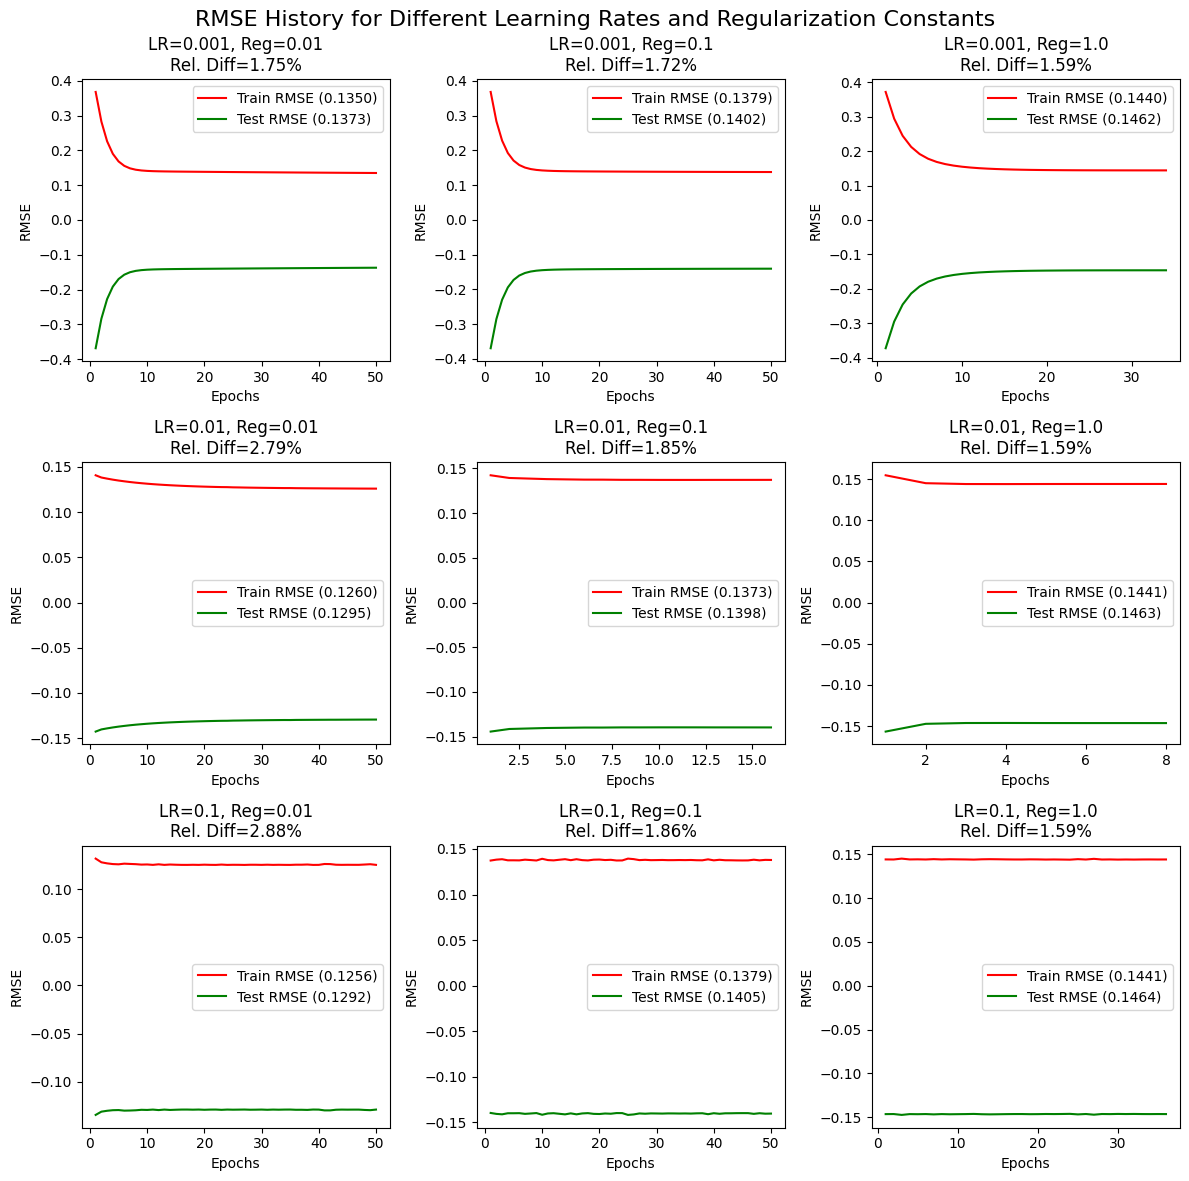

In [156]:
model = RidgeRegression()

learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.01, 0.1, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('RMSE History for Different Learning Rates and Regularization Constants', fontsize=16)

final_test_rmse = []

for i, learning_rate in enumerate(learning_rates):
    for j, reg_constant in enumerate(reg_constants):
        ax = axes[i, j]
        train_rmse_history, test_rmse_history = model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                          initial_learning_rate=learning_rate,
                                                          regularization_constant=reg_constant, i_max=50)
        final_test_rmse.append(test_rmse_history[-1])

        relative_difference = abs(train_rmse_history[-1] - test_rmse_history[-1]) / train_rmse_history[-1]

        ax.plot(range(1, len(train_rmse_history) + 1), train_rmse_history,
                label=f'Train RMSE ({train_rmse_history[-1]:.4f})', color='red')
        ax.plot(range(1, len(test_rmse_history) + 1), -np.array(test_rmse_history),
                label=f'Test RMSE ({test_rmse_history[-1]:.4f})', color='green')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('RMSE')
        ax.set_title(f'LR={learning_rate}, Reg={reg_constant}\nRel. Diff={relative_difference:.2%}')
        ax.legend()

plt.tight_layout()
plt.show()
plt.close()

These plots show how different learning rates and regularization constants affect the model's performance. We see that lower Regression values come along with better RMSE values, because the penalty term is not added in the loss function. We see that the learning rate tends to have the most influence on the behavior of the graph.

Additionally to the task, we also display the relative difference between the Train RMSE and the Test RMSE. Here we can see the (small) effect of a higher Regression Rate, that decreases the relative difference and prevents overfitting.

## Ridge Logistic Regression
Since the Bank dataset is a classification problem, we implement a Logistic Regression model. The model is given as $\hat{y}_n = \sigma(\beta^T x_n + b)$

We define the Loss function as:
$$
Loss = - \sum_{i=1}^{n} [y_i log(\sigma(x_i^T \beta + b)) + (1 - y_i) log(1 - \sigma(x_i^T \beta + b)) ] + \lambda \sum_{j=1}^{P} \beta_j^2
$$

With the gradient with respect to $\beta$:
$$
\Delta_{\beta} Loss = \frac{1}{n} X^T (\sigma(x_i^T \beta + b) - y) + 2 \lambda \beta
$$

And the gradient with respect to the bias:

$$
\Delta_{b} Loss = \frac{1}{n} \sum_{i=1}^n (\sigma(X_i \beta + b) - y_i)
$$

In [129]:
class RidgeLogisticRegression:
    def __init__(self):
        self.B = None
        self.bias = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50, tolerance=1e-3, clip_value=10):
        n, d = X_train.shape
        self.B = np.zeros(d)
        self.bias = 0
        patience = 5
        patience_counter = 0
        best_loss = float('inf')

        train_loss_history = []
        test_loss_history = []

        learning_rate = initial_learning_rate

        for epoch in range(1, i_max + 1):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = 1 / (1 + np.exp(-(X_batch @ self.B + self.bias)))

                gradient_B = (1 / len(y_batch)) * X_batch.T @ (y_pred - y_batch) + 2 * regularization_constant * self.B
                gradient_bias = (1 / len(y_batch)) * np.sum(y_pred - y_batch)

                # Gradient clipping to prevent overflow
                gradient_B_norm = np.linalg.norm(gradient_B)
                if gradient_B_norm > clip_value:
                    gradient_B = (gradient_B / gradient_B_norm) * clip_value

                gradient_bias_norm = np.linalg.norm(gradient_bias)
                if gradient_bias_norm > clip_value:
                    gradient_bias = (gradient_bias / gradient_bias_norm) * clip_value

                self.B -= learning_rate * gradient_B
                self.bias -= learning_rate * gradient_bias

                # We use fixed step length in this model, since bold driver is just making trouble and i just can't figure out how to make it work (It is not a requirement of the task)

            train_loss = self._compute_loss(X_train, y_train, regularization_constant)
            test_loss = self._compute_loss(X_test, y_test, regularization_constant)

            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)

            # we use change in loss improvement as convergence criterion, since the model doesnt seem to improve much after a few iterations
            if abs(train_loss - best_loss) < tolerance:
                patience_counter += 1
            else:
                patience_counter = 0
                best_loss = train_loss

            if patience_counter >= patience:
                return train_loss_history, test_loss_history

        print(f'WARNING: Did not converge after {i_max} epochs!')
        return train_loss_history, test_loss_history

    def predict(self, X):
        return (1 / (1 + np.exp(-X @ self.B + self.bias)) >= 0.5).astype(np.int8)

    def _compute_loss(self, X, y, regularization_constant):
        y_pred = 1 / (1 + np.exp(-(X @ self.B + self.bias)))
        log_likelihood = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        regularization_term = regularization_constant * np.sum(self.B ** 2)
        return log_likelihood + regularization_term


For the classification problem (Bank Marketing dataset), we implement logistic regression with a regularization term (Ridge Logistic Regression). The sigmoid function is used to model probabilities, and the loss function is the negative log-likelihood for binary classification tasks.

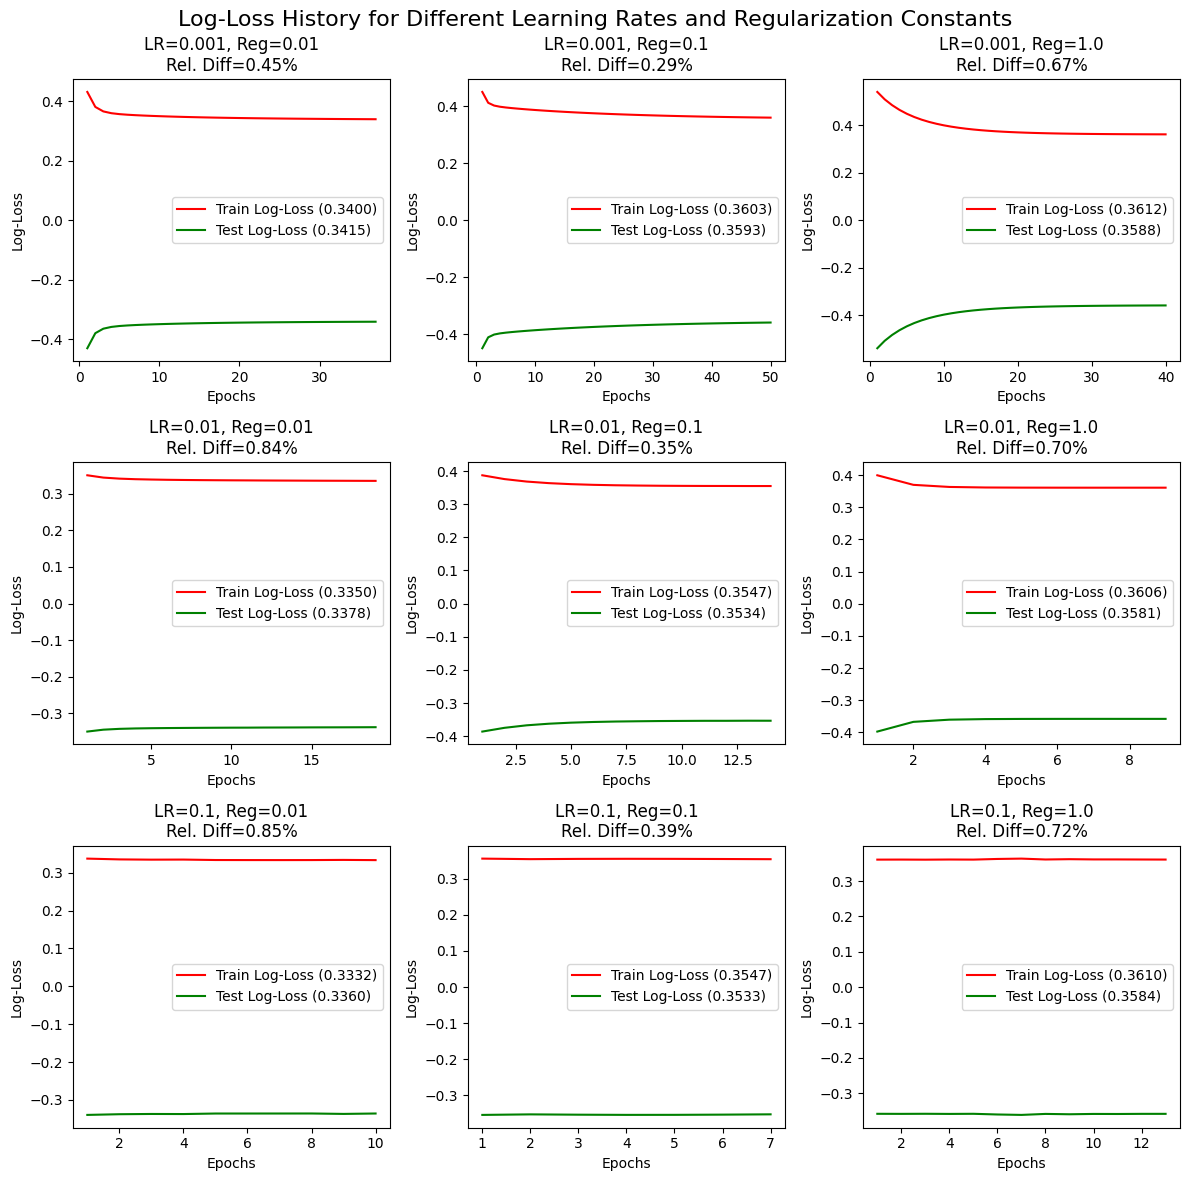

In [128]:
model = RidgeLogisticRegression()

learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.01, 0.1, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Log-Loss History for Different Learning Rates and Regularization Constants', fontsize=16)

final_test_loss = []

for i, learning_rate in enumerate(learning_rates):
    for j, reg_constant in enumerate(reg_constants):
        ax = axes[i, j]

        train_loss_history, test_loss_history = model.fit(X_bank_train, y_bank_train, X_bank_test, y_bank_test,
                                                          initial_learning_rate=learning_rate,
                                                          regularization_constant=reg_constant, i_max=50)

        final_test_loss.append(test_loss_history[-1])

        relative_difference = abs(train_loss_history[-1] - test_loss_history[-1]) / train_loss_history[-1]

        ax.plot(range(1, len(train_loss_history) + 1), train_loss_history,
                label=f'Train Log-Loss ({train_loss_history[-1]:.4f})', color='red')
        ax.plot(range(1, len(test_loss_history) + 1), -np.array(test_loss_history),
                label=f'Test Log-Loss ({test_loss_history[-1]:.4f})', color='green')

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Log-Loss')
        ax.set_title(f'LR={learning_rate}, Reg={reg_constant}\nRel. Diff={relative_difference:.2%}')
        ax.legend()

plt.tight_layout()
plt.show()
plt.close()

The plots show log-loss for different combinations of learning rates and regularization constants.



Unlike the model from above, lower Regression values do not always come along with better log-loss values. But still, We see that the learning rate tends to have the most influence on the behavior of the graph.

Following a similar pattern as the log-loss value, we also display the relative difference between the Train log-loss and the Test log-loss is surprisingly not the lowest for the highest Regression value. Overall, the relative difference is even smaller.

# Hyper-parameter Tuning
Now, we will implement the hyper-parameter tuning for both models.

## Ridge Gradient Descent

In [160]:
def k_fold_cross_validation(X, y, learning_rates, reg_cons, k=5, batch_size=50):
    fold_size = len(y) // k

    rmse_scores = np.zeros((len(learning_rates), len(reg_cons)))

    for lr_idx, lr in enumerate(learning_rates):
        for rc_idx, rc in enumerate(reg_cons):
            rmse_fold_history = []

            for fold in range(k):
                start = fold * fold_size
                end = start + fold_size

                X_test = X[start:end]
                y_test = y[start:end].ravel()
                X_train = np.concatenate([X[:start], X[end:]], axis=0)
                y_train = np.concatenate([y[:start], y[end:]], axis=0).ravel()

                model = RidgeRegression()
                _, test_rmse_history = model.fit(X_train, y_train, X_test, y_test, initial_learning_rate=lr,
                                                 regularization_constant=rc, i_max=200, batch_size=batch_size)

                rmse_fold_history.append(test_rmse_history[-1])

            rmse_scores[lr_idx][rc_idx] = np.mean(rmse_fold_history)

    return rmse_scores


learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
reg_cons = [0.0001, 0.001, 0.01, 0.1, 1]

rmse_scores = k_fold_cross_validation(X_wine_quality.to_numpy(), y_wine_quality.to_numpy(), learning_rates, reg_cons)


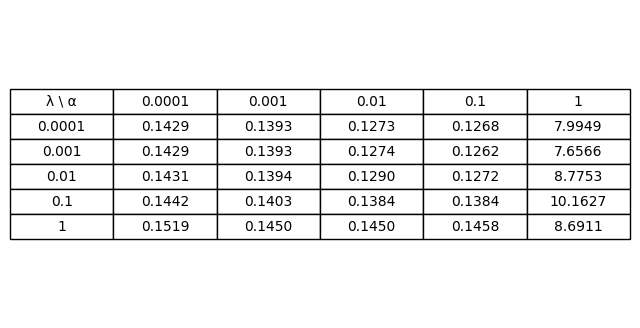

In [161]:
def display_rmse_table(rmse_scores, learning_rates, reg_cons):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    table_data = [["λ \\ α"] + [str(lr) for lr in learning_rates]]
    for i, hp in enumerate(reg_cons):
        row = [str(hp)] + [f"{rmse_scores[j, i]:.4f}" for j in range(len(learning_rates))]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.scale(1, 1.5)

    plt.show()


display_rmse_table(rmse_scores, learning_rates, reg_cons)

The table shows the average RMSE across folds for different learning rate and regularization combinations. In general, it looks like higher step sizes seem to improve the RMSE value, but for values that are too large, it drastically decreases the model's performance.

The opposite is true for the regulation constants, as these add the bias to the loss function to improve overfitting. There seems so be some very little overfitting as the best value for the regulation constant is not the smallest one, but this could also be caused by inaccuracy.

In [162]:
min_idx = np.unravel_index(np.argmin(rmse_scores), rmse_scores.shape)

best_learning_rate = learning_rates[min_idx[0]]
best_reg_cons = reg_cons[min_idx[1]]

print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best Regularization Constant: {best_reg_cons:.4f}')

Best Learning Rate: 0.1000
Best Regularization Constant: 0.0010


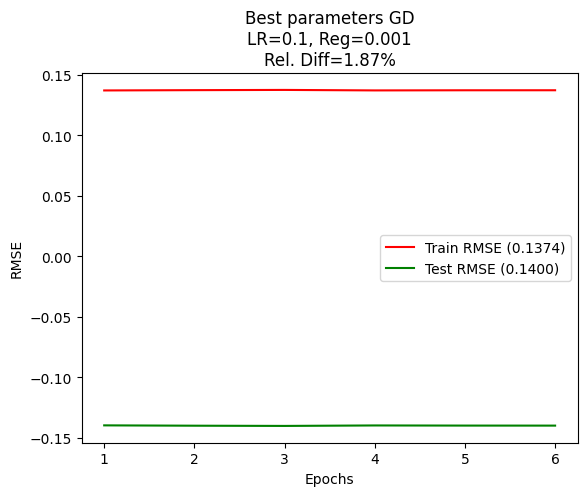

In [164]:
best_model = RidgeRegression()

best_train_rmse_history, best_test_rmse_history = best_model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                                 initial_learning_rate=best_learning_rate,
                                                                 regularization_constant=best_learning_rate, i_max=50,
                                                                 batch_size=50)

relative_difference = abs(best_train_rmse_history[-1] - best_test_rmse_history[-1]) / best_train_rmse_history[-1]

plt.plot(range(1, len(best_train_rmse_history) + 1), best_train_rmse_history,
         label=f'Train RMSE ({best_train_rmse_history[-1]:.4f})', color='red')
plt.plot(range(1, len(best_test_rmse_history) + 1), -np.array(best_test_rmse_history),
         label=f'Test RMSE ({best_test_rmse_history[-1]:.4f})', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.title(f'Best parameters GD\nLR={best_learning_rate}, Reg={best_reg_cons}\nRel. Diff={relative_difference:.2%}')
plt.show()
plt.close()

The plot shows the RMSE history for the training and test sets using the optimal hyperparameters. The model reaches optimal performance almost immediately, as demonstrated by the stable RMSE values from the very first epoch. The training and test RMSE values are close, with a relative difference 1.87%, which indicates good generalization without suffering from performance loss.

## Ridge Logistic Regression



In [144]:
def k_fold_cross_validation_logistic(X, y, learning_rates, reg_cons, k=5, batch_size=50):
    fold_size = len(y) // k
    log_loss_scores = np.zeros((len(learning_rates), len(reg_cons)))

    for lr_idx, lr in enumerate(learning_rates):
        for rc_idx, rc in enumerate(reg_cons):

            log_loss_fold_history = []

            for fold in range(k):
                start = fold * fold_size
                end = start + fold_size

                X_test = X[start:end]
                y_test = y[start:end].ravel()
                X_train = np.concatenate([X[:start], X[end:]], axis=0)
                y_train = np.concatenate([y[:start], y[end:]], axis=0).ravel()

                model = RidgeLogisticRegression()
                _, test_loss_history = model.fit(X_train, y_train, X_test, y_test,
                                                 initial_learning_rate=lr,
                                                 regularization_constant=rc,
                                                 i_max=200, batch_size=batch_size)

                log_loss_fold_history.append(test_loss_history[-1])

            log_loss_scores[lr_idx][rc_idx] = np.mean(log_loss_fold_history)

    return log_loss_scores


learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
reg_cons = [0.0001, 0.001, 0.01, 0.1, 1]

log_loss_scores = k_fold_cross_validation_logistic(X_bank_train, y_bank_train, learning_rates, reg_cons)

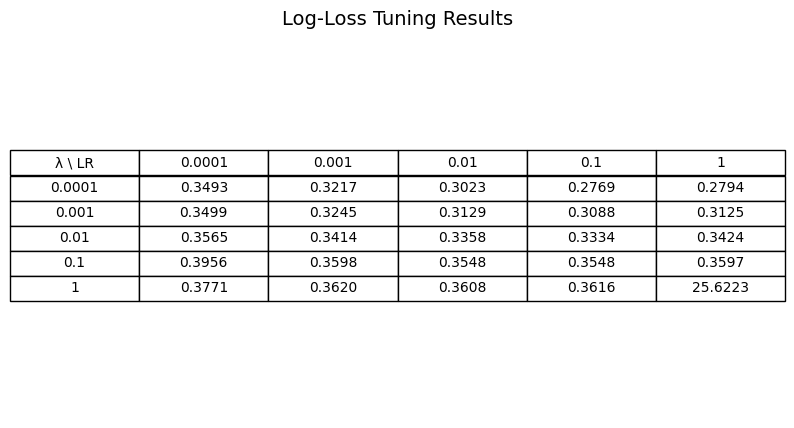

In [145]:
def display_log_loss_results(log_loss_scores, learning_rates, reg_cons):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')

    header = ["λ \\ LR"] + [str(lr) for lr in learning_rates]
    table_data = [header]
    for i, reg in enumerate(reg_cons):
        row = [str(reg)] + [f"{log_loss_scores[j, i]:.4f}" for j in range(len(learning_rates))]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.scale(1, 1.5)

    plt.title("Log-Loss Tuning Results", fontsize=14)
    plt.show()


display_log_loss_results(log_loss_scores, learning_rates, reg_cons)


This table presents the average log-loss across cross-validation folds for different combinations of learning rate and regularization. In general, higher step sizes seem to improve the RMSE value, but for a combination of high step sizes and high regulation constants, it drastically decreases the model's performance.

The opposite is true for the regulation constants, as these add the bias to the loss function to improve overfitting. There does not seem to be noticeable overfitting as the best value for the regulation is not the smallest one tested.

In [146]:
min_idx = np.unravel_index(np.argmin(log_loss_scores), log_loss_scores.shape)
best_learning_rate = learning_rates[min_idx[0]]
best_reg_cons = reg_cons[min_idx[1]]

print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best Regularization Constant: {best_reg_cons:.4f}')

Best Learning Rate: 0.1000
Best Regularization Constant: 0.0001


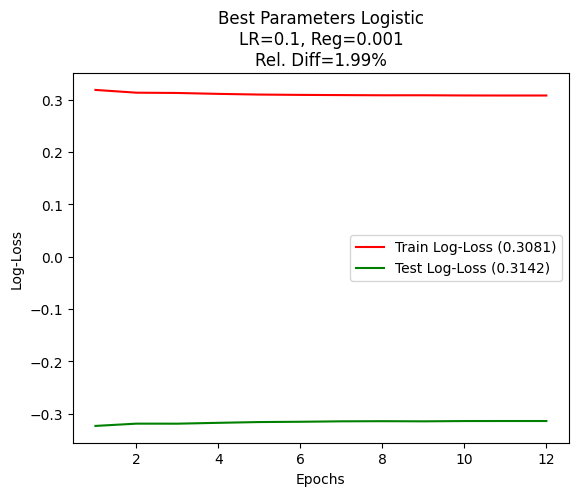

In [166]:
best_model = RidgeLogisticRegression()
best_train_loss_history, best_test_loss_history = best_model.fit(
    X_bank_train, y_bank_train, X_bank_test, y_bank_test,
    initial_learning_rate=best_learning_rate,
    regularization_constant=best_reg_cons,
    i_max=200, batch_size=50)

relative_difference = abs(best_train_loss_history[-1] - best_test_loss_history[-1]) / best_train_loss_history[-1]

plt.plot(range(1, len(best_train_loss_history) + 1), best_train_loss_history,
         label=f'Train Log-Loss ({best_train_loss_history[-1]:.4f})', color='red')

plt.plot(range(1, len(best_test_loss_history) + 1), -np.array(best_test_loss_history),
         label=f'Test Log-Loss ({best_test_loss_history[-1]:.4f})', color='green')

plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.legend()

plt.title(
    f'Best Parameters Logistic\nLR={best_learning_rate}, Reg={best_reg_cons}\nRel. Diff={relative_difference:.2%}')
plt.show()
plt.close()

The plot shows the log-loss history for the training and test sets using the optimal hyperparameters. The model reaches optimal performance quickly, with some small improvements across the first few epochs. The training and test log-loss values are close, with a relative difference of 1.99%, which indicates good generalization without suffering from performance loss.

This week, we implemented Ridge Regression and Ridge Logistic Regression for the wine and bank datasets. We tuned learning rates and regularization constants with cross-validation to find good parameters. Both models converged quickly but often leveled out early, which might mean we could improve the learning rate schedule or convergence criteria. The relative differences between training and test errors were small, showing decent generalization, but there might still be room for some tweaks to get better results. I won't be able to implement these because I'm not available over the weekend, and it's already late Thursday night.